In [1]:
# Imports for JupyterLite
%pip install -q ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
from fastai.tabular.all import *
import matplotlib.pyplot as plt
import ipywidgets as widgets
import concurrent.futures
import urllib.request

# Adjust this based on data availibility
# The quality of predictions decline rapidly after Oct 2023 so let's zoom on that for now
# FIRST_DAY = pd.Timestamp("2023-10-01")
FIRST_DAY = pd.Timestamp("2012-01-01")

# When the data analysis should stop
# The quality of predictions decline rapidly after Oct 2023 so let's zoom on that for now
LAST_DAY = pd.Timestamp("2024-04-10")

def filter_known_range(df):
  return df[(df['datetime'] >= FIRST_DAY) & (df['datetime'] < LAST_DAY)]

In [3]:
def get_csv(url, local_filename):
    if not os.path.exists(local_filename):
        print(f"{local_filename} not found locally. Downloading and reading from URL...")
        df = pd.read_csv(url)
        df.to_csv(local_filename, index=False)  # Save the downloaded file locally
    else:
        print(f"Reading {local_filename} from local storage...")
        df = pd.read_csv(local_filename)
    return df

In [4]:
# MONTREAL/PIERRE ELLIOTT TRUDEAU INTL QUEBEC
# This station has precipitation but doesn't have a categorical value of weather (e.g cloudy, rain, etc)
station_id = "30165"

years = range(FIRST_DAY.year, LAST_DAY.year + 1)
months = range(1, 13)

dates = [(month, year) for year in years for month in months]
urls = list(map(lambda xy: f"https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={station_id}&Year={xy[1]}&Month={xy[0]}&Day=1&timeframe=1&submit=Download+Data", dates))

def get_weather_csv(url):
    filename = url.split('&Year=')[1].split('&Month=')[0] + '-' + url.split('&Month=')[1].split('&Day=')[0] + '.csv'
    filepath = f'./weather_{filename}'
    if os.path.exists(filepath):
        return filepath
    try:
        # Download and save the file
        with urllib.request.urlopen(url, timeout=30) as response, open(filepath, 'wb') as out_file:
            out_file.write(response.read())
        return filepath
    except Exception as e:
        print(f"Failed to download {url}: {str(e)}")
        return None

# Use a ThreadPoolExecutor to manage concurrent downloads
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # Start the load operations and mark each future with its URL
    future_to_url = {executor.submit(get_weather_csv, url): url for url in urls}
    for future in concurrent.futures.as_completed(future_to_url):
        url = future_to_url[future]
        try:
            filepath = future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (url, exc))


In [5]:
def plot_preds(df):
    dates = pd.date_range(start=df['datetime'].min(), end=df['datetime'].max(), freq='D')
    options = [(date.strftime(' %Y-%m-%d '), date) for date in dates]

    date_range_slider = widgets.SelectionRangeSlider(
        options=options,
        index=(0, len(options)-1),
        description='Select Date Range',
        orientation='horizontal',
        layout={'width': '500px'}
    )

    def update_plot(date_range):
        # Filter the DataFrame for the selected date range
        start_date, end_date = date_range
        mask = (df['datetime'] >= start_date) & (df['datetime'] <= end_date)
        filtered_df = df.loc[mask].set_index('datetime')

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(filtered_df['Actual'], label='Actual AQI', color='blue')
        plt.plot(filtered_df['Predicted'], label='Predicted AQI', color='red', alpha=0.6)
        plt.title('Comparison of Actual and Predicted AQI')
        plt.xlabel('Date')
        plt.ylabel('AQI Value')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Connect the SelectionRangeSlider to the update_plot function
    widgets.interact(update_plot, date_range=date_range_slider)

# Weather data exploration

- [Glossary](https://climate.weather.gc.ca/glossary_e.html)

In [6]:
all_files = []
for filename in os.listdir("."):
  if filename.startswith("weather_"):
    all_files.append(pd.read_csv(filename))

weather_df = pd.concat(all_files)

weather_df.rename(columns={'Date/Time (LST)': 'datetime', "Temp (°C)": "temp", "Precip. Amount (mm)": "precip", "Rel Hum (%)": "rel_humid"}, inplace=True)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])



# TODO: for the temp we should look at the day before or after instead of using 0
weather_df.fillna({"precip": 0, "temp": 0, "rel_humid": weather_df['rel_humid'].mode()[0]}, inplace=True)
weather_df = weather_df[['datetime', "precip", "temp", "rel_humid"]]


# Only take data from the first known and last known day
weather_df = filter_known_range(weather_df)

weather_df.sort_values("datetime", inplace=True)

assert weather_df[weather_df.isna().any(axis=1)].empty == True

weather_df

,datetime,precip,temp,rel_humid
0,2012-01-01 00:00:00,0.0,0.0,73.0
1,2012-01-01 01:00:00,0.0,0.0,73.0
2,2012-01-01 02:00:00,0.0,0.0,73.0
3,2012-01-01 03:00:00,0.0,0.0,73.0
4,2012-01-01 04:00:00,0.0,0.0,73.0
...,...,...,...,...
211,2024-04-09 19:00:00,0.0,15.0,35.0
212,2024-04-09 20:00:00,0.0,13.4,37.0
213,2024-04-09 21:00:00,0.0,12.6,37.0
214,2024-04-09 22:00:00,0.0,11.7,38.0


# AQI data exploration

### Further improvements
- [ ] External data
- [ ] Different date feature engineering approach
- [ ] Remove/leave pollutant
- [ ] Model ensembling
- [ ] LSTMs https://medium.com/@masterofchaos/lstms-made-easy-a-simple-practical-approach-to-time-series-prediction-using-pytorch-fastai-103dd4f27b82
- [x] Use random forests
- [ ] Weight decay to avoid overfitting


Compare results with https://aqicn.org/city/montreal/

In [7]:
df1 = get_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/0c325562-e742-4e8e-8c36-971f3c9e58cd/download/rsqa-indice-qualite-air-2022-2024.csv', '2022-2024.csv')
df2 = get_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/e43dc1d6-fbdd-49c3-a79f-83f63404c281/download/rsqa-indice-qualite-air-2019-2021.csv', '2019-2021.csv')
df3 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/93a3a88e-97ab-4ab1-813f-5419a1dd330d/download/rsqa-indice-qualite-air-2016-2018.csv", "2016-2018.csv")
df4 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/02cfaf0c-3b46-4dac-bf66-acd2ff47361a/download/rsqa-indice-qualite-air-2013-2015.csv", "2013-2015.csv")
df5 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/6e59c6e9-749b-4237-9c45-5c627be2b7ad/download/rsqa-indice-qualite-air-2010-2012.csv", "2010-2012.csv")

2022-2024.csv not found locally. Downloading and reading from URL...
2019-2021.csv not found locally. Downloading and reading from URL...
2016-2018.csv not found locally. Downloading and reading from URL...
2013-2015.csv not found locally. Downloading and reading from URL...
2010-2012.csv not found locally. Downloading and reading from URL...


In [9]:
df = pd.concat([df1, df2, df3, df4, df5])
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['heure'].astype(str) + ':00:00',
                                format = '%Y-%m-%d %H:%M:%S',
                                errors = 'coerce')
df.drop(["heure", "polluant", "date"], axis=1, inplace=True)
df.sort_values("datetime", inplace=True)

# Taking a sample of data for a given datetime and station id
# df[(df["stationId"] == 103) & (df["datetime"] == "2024-04-15 19:00:00")]

df = filter_known_range(df)

assert df[df.isna().any(axis=1)].empty == True
df

,stationId,valeur,datetime
584289,55,7,2012-01-01 00:00:00
591367,28,35,2012-01-01 00:00:00
591366,28,6,2012-01-01 00:00:00
584288,55,1,2012-01-01 00:00:00
664507,61,1,2012-01-01 00:00:00
...,...,...,...
764425,3,1,2024-04-09 23:00:00
764429,6,2,2024-04-09 23:00:00
764427,6,2,2024-04-09 23:00:00
764428,6,18,2024-04-09 23:00:00


In [10]:
# the data contains measurements across various stations (spread over the MTL territory).
# We can take the maximum measurement for a given station for a given datetime (regardless of the pollutant).
# Note: we are assuming each pollutant contributes equally to the AQI level
# (Using the maximum pollutant value as a representative AQI is simplistic. Real AQI calculation may involve more complex computations where different pollutants have different weights or scale adjustments based on their health impact.)
group1_df = df.groupby(['stationId', 'datetime']).max("valeur")

# Manually verifying the maximum has been taken for a given station id on a given datetime
group1_df

valeur
stationId datetime                   
3         2012-01-01 00:00:00      26
          2012-01-01 01:00:00      30
          2012-01-01 02:00:00      36
          2012-01-01 03:00:00      38
          2012-01-01 04:00:00      39
...                               ...
103       2024-04-09 19:00:00      25
          2024-04-09 20:00:00      20
          2024-04-09 21:00:00      22
          2024-04-09 22:00:00      22
          2024-04-09 23:00:00      21

[1144171 rows x 1 columns]

In [68]:
from sklearn.preprocessing import MinMaxScaler


# Get the mean across all station maximums for each datetime
group2_df = group1_df.groupby("datetime").mean("valeur")
group2_df.reset_index(inplace=True)

merged = pd.merge(group2_df, weather_df, on="datetime", how="left")

merged['year'] = merged['datetime'].dt.year
# Year has a bigger number range than the rest so we divide it up by its maximum
# merged['year'] = merged['year'] / merged['year'].max()
merged['month'] = merged['datetime'].dt.month
merged['day'] = merged['datetime'].dt.day
merged['weekday'] = merged['datetime'].dt.weekday
merged['hour'] = merged['datetime'].dt.hour

# TODO: not clamping result in a lower loss but weirdly wrose predictions. Perhaps the model doesn't generalize as good?
merged['valeur'] = merged['valeur'].clip(upper=100)

scaler = MinMaxScaler()
# Fit the scaler to the clamped data and transform it
merged['valeur'] = scaler.fit_transform(merged[['valeur']])

# merged[merged['datetime'] >= pd.Timestamp("2023-10-01")]
merged


,datetime,valeur,precip,temp,rel_humid,year,month,day,weekday,hour
0,2012-01-01 00:00:00,0.259416,0.0,0.0,73.0,2012,1,1,6,0
1,2012-01-01 01:00:00,0.297740,0.0,0.0,73.0,2012,1,1,6,1
2,2012-01-01 02:00:00,0.317420,0.0,0.0,73.0,2012,1,1,6,2
3,2012-01-01 03:00:00,0.317420,0.0,0.0,73.0,2012,1,1,6,3
4,2012-01-01 04:00:00,0.310169,0.0,0.0,73.0,2012,1,1,6,4
...,...,...,...,...,...,...,...,...,...,...
107587,2024-04-09 19:00:00,0.200565,0.0,15.0,35.0,2024,4,9,1,19
107588,2024-04-09 20:00:00,0.184557,0.0,13.4,37.0,2024,4,9,1,20
107589,2024-04-09 21:00:00,0.178908,0.0,12.6,37.0,2024,4,9,1,21
107590,2024-04-09 22:00:00,0.168550,0.0,11.7,38.0,2024,4,9,1,22


In [69]:

# Train data goes from FIRST_DAY (~2016) to 2021-05-31
split_date_valid = pd.Timestamp('2021-06-01')

# Validation data goes from 2021-06-01 to 2022-12-31
split_date_test = pd.Timestamp('2023-01-01')

# Test data goes from 2023-01-01 to LAST_DAY

train_idx = merged['datetime'] < split_date_valid
valid_idx = (merged['datetime'] >= split_date_valid) & (merged['datetime'] < split_date_test)
test_idx = merged['datetime'] >= split_date_test

train_idxs = np.where(train_idx)[0].tolist()
valid_idxs = np.where(valid_idx)[0].tolist()
test_idxs = np.where(test_idx)[0].tolist()

len(merged.loc[train_idxs]), len(valid_idxs)

(82536, 13896)

In [70]:
to = TabularPandas(
  merged,
  procs=[Categorify, Normalize],
  cat_names=['weekday', 'hour', 'month', 'day'],
  cont_names=['year', "precip", "temp", "rel_humid"],
  y_names=['valeur'],
  splits=(train_idxs, valid_idxs),
  y_block=RegressionBlock()
)

dls = to.dataloaders(bs=1024)

dls.show_batch()


,weekday,hour,month,day,year,precip,temp,rel_humid,valeur
0,5,12,8,17,2019.0,1.572871e-09,26.100000,66.000000,0.248023
1,0,13,6,5,2017.0,2.700000e+00,14.000000,93.000000,0.096798
2,4,15,4,10,2020.0,1.572871e-09,6.300000,61.000000,0.168550
3,1,12,9,1,2015.0,1.572871e-09,24.200000,65.000000,0.152961
4,1,5,9,24,2019.0,3.000000e-01,13.899999,90.999999,0.037874
5,0,1,8,26,2013.0,1.572871e-09,17.200001,89.000000,0.215631
6,2,2,3,23,2016.0,3.000000e-01,0.500000,100.000000,0.203390
7,0,1,9,26,2016.0,1.572871e-09,6.600000,86.999999,0.092655
8,2,5,5,13,2015.0,1.572871e-09,7.000000,67.000000,0.138230
9,4,21,2,23,2018.0,3.000000e-01,0.900000,99.000000,0.098870


# Neural net impl

In [71]:
learn = tabular_learner(dls, metrics=mae, layers=[500, 250], y_range=(0, 1))

SuggestedLRs(valley=0.0012022644514217973, slide=0.2089296132326126)

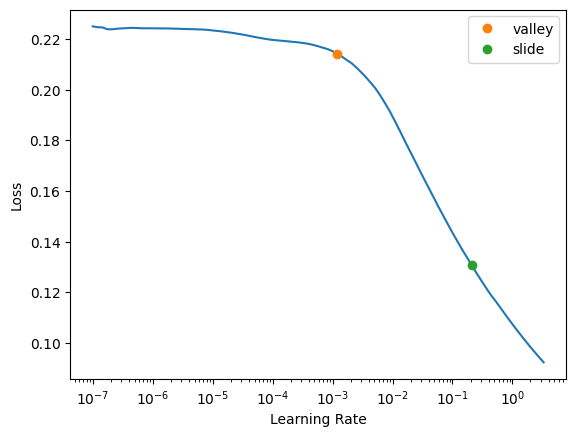

In [33]:
learn.lr_find(suggest_funcs=[valley, slide])

In [72]:
learn.fit_one_cycle(10, 0.01)

epoch,train_loss,valid_loss,mae,time
0,0.048031,0.023069,0.102427,00:04
1,0.012072,0.004075,0.043799,00:03
2,0.005075,0.003974,0.042618,00:03
3,0.003363,0.004351,0.045249,00:03
4,0.002661,0.003502,0.039683,00:04
5,0.002226,0.004014,0.042598,00:03
6,0.001876,0.003866,0.040079,00:03
7,0.001613,0.003769,0.039490,00:03
8,0.001358,0.003793,0.039516,00:04
9,0.001217,0.003651,0.038907,00:03


In [79]:
def mk_analysis_df(df, preds, scaler):
  # return pd.DataFrame({'datetime': df['datetime'],
  #             'Actual': df['valeur'],
  #             'Predicted': scaler.inverse_transform(preds) })
  # Reverse scaling of predictions
  preds_rescaled = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
  value_rescaled = scaler.inverse_transform(df['valeur'].values.reshape(-1, 1)).flatten()

  # Create DataFrame
  return pd.DataFrame({
      'datetime': df['datetime'],
      'Actual': value_rescaled,
      'Predicted': preds_rescaled
  })

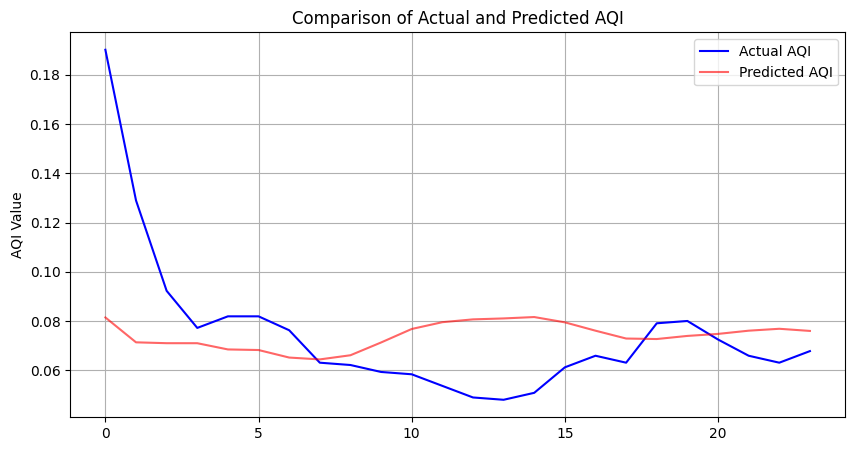

In [54]:
# # learn.recorder.plot_loss()
# learn.show_results(max_n=10)

df = merged.loc[test_idxs]
test_dl = dls.test_dl(df)
preds, targets = learn.get_preds(dl=test_dl)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(targets[:24], label='Actual AQI', color='blue')
plt.plot(preds[:24], label='Predicted AQI', color='red', alpha=0.6)
plt.title('Comparison of Actual and Predicted AQI')
plt.ylabel('AQI Value')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
df_test = merged.loc[test_idxs]
test_dl = dls.test_dl(df_test)

In [75]:
preds, targets = learn.get_preds(dl=test_dl)

mae(preds, targets)

TensorBase(0.0549)

In [81]:
analysis_df = mk_analysis_df(df_test, preds.flatten(), scaler)

# plot_preds(analysis_df)
plot_preds(analysis_df[analysis_df['datetime'] >= pd.Timestamp("2020-01-01")])

interactive(children=(SelectionRangeSlider(description='Select Date Range', index=(0, 464), layout=Layout(widt…

# Random forest impl

_RandomForest doesn't seem to offer much better results than using deep learning for this dataset._

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import torch

m = RandomForestRegressor(n_jobs=-1, n_estimators=100,
        max_samples=10_000, max_features=0.5,
        min_samples_leaf=5, oob_score=True).fit(dls.train.xs, dls.train.y)
preds = m.predict(dls.valid.xs)
preds_tensor = torch.tensor(preds)

mae(preds_tensor, torch.tensor(dls.valid.y.values))

TensorBase(3.4242)

In [ ]:
df_test = merged.loc[test_idxs]
test_dl = dls.test_dl(df_test)

In [ ]:
preds = torch.tensor(m.predict(test_dl.xs))
mae(preds, torch.tensor(test_dl.y.values))

TensorBase(4.5673)

In [ ]:
def mk_analysis_df(df, preds):
  return pd.DataFrame({'datetime': df['datetime'],
              'Actual': df['valeur'],
              'Predicted': preds })

analysis_df = mk_analysis_df(df_test, preds)
analysis_df

,datetime,Actual,Predicted
61368,2023-01-01 00:00:00,21.818182,18.796947
61369,2023-01-01 01:00:00,15.909091,19.415405
61370,2023-01-01 02:00:00,12.363636,19.047986
61371,2023-01-01 03:00:00,10.909091,18.071020
61372,2023-01-01 04:00:00,11.363636,17.989505
...,...,...,...
72523,2024-04-09 19:00:00,22.818182,21.884124
72524,2024-04-09 20:00:00,21.272727,21.065109
72525,2024-04-09 21:00:00,20.727273,20.415613
72526,2024-04-09 22:00:00,19.727273,19.543265


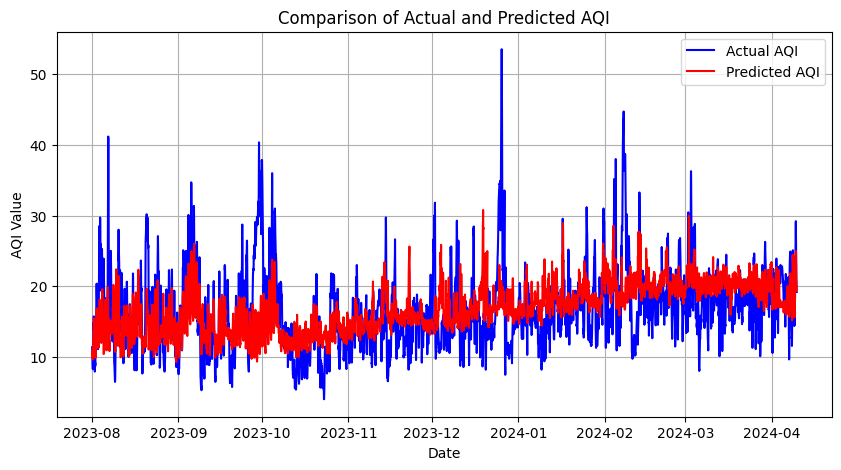

In [ ]:
plot_preds(analysis_df[analysis_df['datetime'] >= pd.Timestamp("2023-08-01")])